<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week6/LSTM-Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import seaborn as sns


In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Load data
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)
if response.status_code == 200:
    try:
        # Try to read as newline-delimited JSON
        df = pd.read_json(url, lines=True)
    except ValueError:
        # If that fails, try to read as a list of dictionaries
        data = json.loads(response.text)
        df = pd.DataFrame(data)
else:
    print("Failed to download data, check URL or internet connection.")

print("Data shape:", df.shape)
print("\nSample data:")
print(df.head())

Data shape: (26709, 3)

Sample data:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [6]:
# Data preprocessing
def clean_text(text):
    """Clean the text by removing special characters, links, etc."""
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        return text
    return ""


In [7]:
# Clean text data
df['headline'] = df['headline'].apply(clean_text)

# Split data
X = df['headline']
y = df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Tokenize text
max_words = 10000  # Maximum number of words to consider
max_sequence_length = 100  # Maximum length of each sequence

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index


In [9]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')


In [10]:
# Function to build the LSTM model (will be used for hyperparameter tuning)
def build_model(hp):
    # Define input
    input_layer = Input(shape=(max_sequence_length,))

    # Embedding layer
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    x = Embedding(input_dim=max_words, output_dim=embedding_dim)(input_layer)

    # LSTM layer(s)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    bidirectional = hp.Boolean('bidirectional')
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    if bidirectional:
        x = Bidirectional(LSTM(lstm_units, return_sequences=hp.Boolean('return_sequences')))(x)
    else:
        x = LSTM(lstm_units, return_sequences=hp.Boolean('return_sequences'))(x)

    x = Dropout(dropout_rate)(x)

    # Add another LSTM layer if return_sequences is True
    if hp.Boolean('return_sequences'):
        lstm_units_2 = hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
        if bidirectional:
            x = Bidirectional(LSTM(lstm_units_2))(x)
        else:
            x = LSTM(lstm_units_2)(x)
        x = Dropout(dropout_rate)(x)

    # Dense layers
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                 tf.keras.metrics.AUC()]
    )

    return model


In [12]:
# Hyperparameter tuning using Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='keras_tuner',
    project_name='sarcasm_detection'
)

In [13]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [14]:
# Run hyperparameter search
tuner.search(
    X_train_padded,
    y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Trial 3 Complete [00h 00m 50s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.857510507106781
Total elapsed time: 00h 02m 45s


In [15]:
# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest Hyperparameters: {best_hps.values}")



Best Hyperparameters: {'embedding_dim': 128, 'lstm_units': 32, 'bidirectional': True, 'dropout_rate': 0.4, 'return_sequences': False, 'dense_units': 64, 'learning_rate': 0.0006425128602850993, 'lstm_units_2': 16}


In [16]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)


In [17]:
# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [19]:
# Train the best model
history = best_model.fit(
    X_train_padded,
    y_train,
    epochs=7,  # Increase for better results
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/7
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9648 - auc_3: 0.9904 - loss: 0.1114 - precision_3: 0.9635 - recall_3: 0.9565
Epoch 1: val_accuracy did not improve from 0.85423
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9647 - auc_3: 0.9903 - loss: 0.1117 - precision_3: 0.9633 - recall_3: 0.9564 - val_accuracy: 0.8456 - val_auc_3: 0.9230 - val_loss: 0.4286 - val_precision_3: 0.8163 - val_recall_3: 0.8437
Epoch 2/7
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9720 - auc_3: 0.9941 - loss: 0.0887 - precision_3: 0.9675 - recall_3: 0.9692
Epoch 2: val_accuracy did not improve from 0.85423
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9720 - auc_3: 0.9941 - loss: 0.0887 - precision_3: 0.9675 - recall_3: 0.9692 - val_accuracy: 0.8346 - val_auc_3: 0.9135 - val_loss: 0.5402 - val_precision_3: 0.8212 - val_recall_3: 0.8044
Epoch 3/7
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9833 - auc_3: 0.9971 - loss: 0.0563 - precision_3: 0.9824 

In [20]:
# Evaluate the model on the test set
y_pred_prob = best_model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [21]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("\nTest Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")



Test Metrics:
Accuracy: 0.8443
Precision: 0.8120
Recall: 0.8397
F1 Score: 0.8256
AUC: 0.9238


In [22]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2996
           1       0.81      0.84      0.83      2346

    accuracy                           0.84      5342
   macro avg       0.84      0.84      0.84      5342
weighted avg       0.85      0.84      0.84      5342



In [23]:
# Visualize training history
plt.figure(figsize=(12, 5))


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

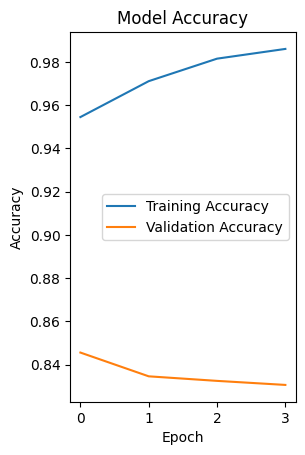

In [24]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

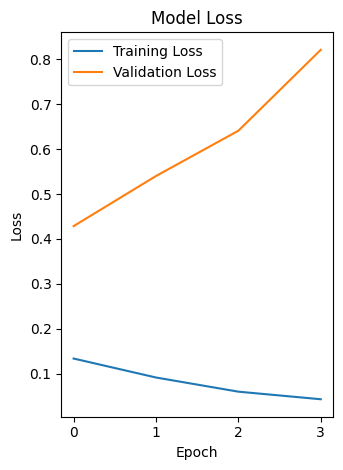

In [26]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

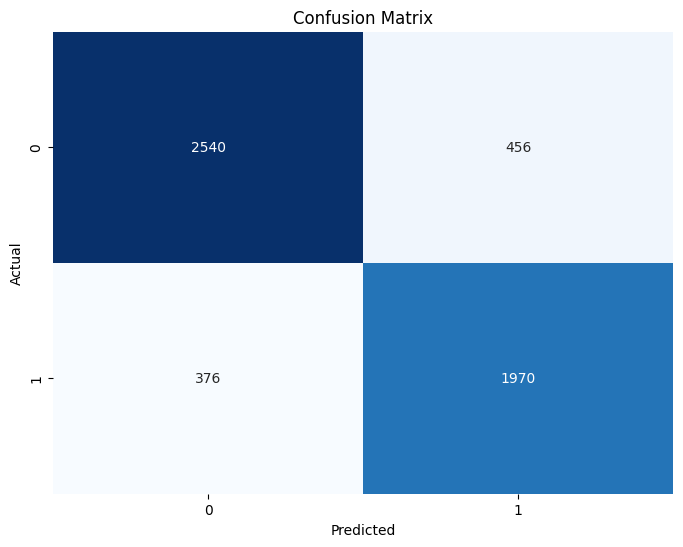

In [27]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

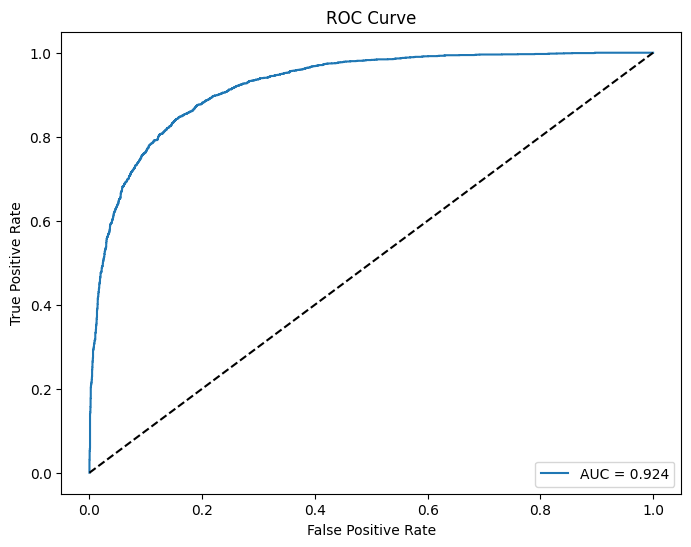

In [28]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()